## Tasks
Assigned to Sierra Stevenson, JSIP intern under Dr. Jonathan Jiang and Dr. Longtao Wu

Instructions: For each region (slice lat/lon), make a PDF for each time iteration (sel every 3 hrs for both datasets), then average the PDFs

List of Tasks<p>
[DONE]&nbsp;&nbsp;&nbsp;Task 1 — UM moisture at 100 hPa map<br>
[DONE]&nbsp;&nbsp;&nbsp;Task 2 — MLS moisture at 100 hPa map<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Task 3 — UM/MLS/AIRS vert. profiles moisture vs temp/pressure<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Task 4 — UM/MLS PDFs (moisture)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Task 5 — UM/GPM_MERGIR PDFs (brightness temp)

In [3]:
# for logging in:
#    username = smsteven
#    password = 2bhzvjM5YfhV.

## Code
Setup

In [4]:
# Import libraries

# NASA Earthdata authorization
from subprocess import Popen
from getpass import getpass
import platform
import os
import shutil

# Data analysis/access
import parmap
import below_god as bg
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/users/smsteven/.conda/envs/jsip/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [207]:
# Helper items

# Conversion factors
hPa_to_Pa = 100
kgkg_to_ppmv = 1.608 * 10 ** 6
VMR_to_ppmv = 10 ** 6

# Monsoon region coordinates (format: [lon1,lon2,lat1,lat2])
# Asian Monsoon
AM_coords = [20, 160,-10,50]
AM_box = [[20,40],[40,140]]

# North American Monsoon
NAM_coords = [-140,-40,-10,50]
NAM_box = [[-10,40],[-140,60]]

# Function to narrow down lat/lon range to just Asian or North American Monsoon region
def RegionSelect(xarr, region):
    if region == "AM":
        return xarr.sel(latitude=slice(AM_coords[2],AM_coords[3])).sel(longitude=slice(AM_coords[0],AM_coords[1]))
    elif region == "NAM":
        return xarr.sel(latitude=slice(NAM_coords[2],NAM_coords[3])).sel(longitude=slice(NAM_coords[0],AM_coords[1]))
    else:
        print("Region must be either AM or NAM.")

def Create1D(arr):
    # Get number of time elements to iterate through
    ntimes = len(arr['time'])

    # Narrow down data array to target monsoon regions
    arr_AM = RegionSelect(arr, "AM")
    arr_NAM = RegionSelect(arr, "NAM")

    # Create first time entry in array
    print("Creating first entries for each region.")
    arr_AM_tot = arr_AM[0].to_numpy().ravel()     # Asian Monsoon
    arr_NAM_tot = arr_NAM[0].to_numpy().ravel()   # North American Monsoon

    # Loop through time and flatten to create large 1D array
    print("Beginning loop. This will take a while.")
    for t in range(ntimes):
        np.append(arr_AM_tot, arr_AM[t].to_numpy().ravel())
        np.append(arr_NAM_tot, arr_NAM[t].to_numpy().ravel())
        if t%20 == 0:
            print(f"Beginning iteration {t+1}...")
    print("Loop complete; 1D arrays returned.")

    return arr_AM_tot, arr_NAM_tot

Load in existing files

In [ ]:
files_loaded = False
path_temp = '/users/smsteven/Tasks/Code/'   # TODO: Clean up later by moving files to Figures and changing this path
# path = '/users/smsteven/Tasks/Files/'

try:
    GPM_OLR_AM = np.load(path_temp+'GPM_OLR_AM.npy')
    GPM_OLR_NAM = np.load(path_temp+'GPM_OLR_NAM.npy')
    UM_OLR_AM = np.load(path_temp+'UM_OLR_AM.npy')
    UM_OLR_NAM = np.load(path_temp+'UM_OLR_NAM.npy')
    MLS_h2o100_hrly_flat = np.load(path_temp+'MLS_h2o100_hrly_flat.npy')
    UM_hus100  = np.load(path_temp+'UM_hus_100hPa.npy')    # UM moisture at 100 hPa
except:
    print("At least one file not loaded; the following code blocks will create these files.")
else:
    files_loaded = True
    print("Files loaded successfully. The following code blocks will be skipped.")

### MLS data

In [ ]:
# # if not files_loaded:
# # Read in MLS hourly data from below_god
# # Path and date range
# path = "/data/emls/l2gp/v05.01/2016/"
# yday_range = np.arange(224,252+1)   # 08/11 - 09/08 (double check)

# # Find min length of hourly data
# lim = 4000
# for day in yday_range:
#     # print(day)
#     if len(bg.io.read_l2gp(f'/data/emls/l2gp/v05.01/2016/{day}/MLS-Aura_L2GP-H2O_v05-01-c01_2016d{day}.he5')['value']) < lim:
#         lim = len(bg.io.read_l2gp(f'/data/emls/l2gp/v05.01/2016/{day}/MLS-Aura_L2GP-H2O_v05-01-c01_2016d{day}.he5')['value'])
# print(f"The minimum length of 'profile' values in the MLS L2 hourly datasets is {lim}.")

# # Initialize xarray with first day
# MLS_hrly = bg.io.read_l2gp('/data/emls/l2gp/v05.01/2016/224/MLS-Aura_L2GP-H2O_v05-01-c01_2016d224.he5')['value'][:lim]

# # Fill in rest of hourly datasets
# for day in yday_range:
#     new = bg.io.read_l2gp(f'/data/emls/l2gp/v05.01/2016/{day}/MLS-Aura_L2GP-H2O_v05-01-c01_2016d{day}.he5')['value'][:lim]
#     MLS_hrly = xr.concat([MLS_hrly, new], dim='day', join='inner')

# # Screening: Need to ask Ryan/Longtao

# # Select moisture where pressure = 100 hPa and convert to ppmv
# # MLS_h2o100_hrly = MLS_hrly.sel(lev=100) * VMR_to_ppmv
# # MLS_h2o100_hrly_arr = np.array(MLS_h2o100_hrly)
# # MLS_h2o100_hrly_flat = MLS_h2o100_hrly_arr.ravel()
# # np.save("MLS_h2o100_hrly_flat", MLS_h2o100_hrly_flat)

In [325]:
# if not files_loaded:
# Read in MLS hourly data from below_god
# Path and date range
path = "/data/emls/l2gp/v05.01/2016/"
yday_range = np.arange(224,252+1)   # 08/11 - 09/08 (double check)

# Find min length of hourly data
lim = 4000
for day in yday_range:
    # print(day)
    if len(bg.io.read_l2gp(f'/data/emls/l2gp/v05.01/2016/{day}/MLS-Aura_L2GP-H2O_v05-01-c01_2016d{day}.he5')['value']) < lim:
        lim = len(bg.io.read_l2gp(f'/data/emls/l2gp/v05.01/2016/{day}/MLS-Aura_L2GP-H2O_v05-01-c01_2016d{day}.he5')['value'])
print(f"The minimum length of 'profile' values in the MLS L2 hourly datasets is {lim}.")

# Initialize xarray with first day
MLS_hrly = bg.io.read_l2gp('/data/emls/l2gp/v05.01/2016/224/MLS-Aura_L2GP-H2O_v05-01-c01_2016d224.he5').sel(profile=slice(0,lim))

# Fill in rest of hourly datasets
for day in yday_range:
    new = bg.io.read_l2gp(f'/data/emls/l2gp/v05.01/2016/{day}/MLS-Aura_L2GP-H2O_v05-01-c01_2016d{day}.he5').sel(profile=slice(0,lim))
    MLS_hrly = xr.concat([MLS_hrly, new], dim='day', join='inner')

# Screening: Need to ask Ryan/Longtao

# Select moisture where pressure = 100 hPa and convert to ppmv
# MLS_h2o100_hrly = MLS_hrly.sel(lev=100) * VMR_to_ppmv
# MLS_h2o100_hrly_arr = np.array(MLS_h2o100_hrly)
# MLS_h2o100_hrly_flat = MLS_h2o100_hrly_arr.ravel()
# np.save("MLS_h2o100_hrly_flat", MLS_h2o100_hrly_flat)

The minimum length of 'profile' values in the MLS L2 hourly datasets is 3402.


In [404]:
MLS = MLS_hrly
MLS_100 = MLS.sel(lev=100) * VMR_to_ppmv
MLS_NAM = MLS_100.where(MLS_100.lon > 30, drop=True)
MLS_NAM_arr = np.array(MLS_NAM['value']).ravel()
MLS_NAM_arr = MLS_NAM_arr[~np.isnan(MLS_NAM_arr)]

### GPM_MERGIR data

In [9]:
if not files_loaded:
    # Get authorization to access GPM data archive ###########################

    urs = 'urs.earthdata.nasa.gov'    # Earthdata URL to call for authentication
    prompts = ['Enter NASA Earthdata Login Username \n(or create an account at urs.earthdata.nasa.gov): ',
            'Enter NASA Earthdata Login Password: ']

    homeDir = os.path.expanduser("~") + os.sep

    with open(homeDir + '.netrc', 'w') as file:
        file.write('machine {} login {} password {}'.format(urs, getpass(prompt=prompts[0]), getpass(prompt=prompts[1])))
        file.close()
    with open(homeDir + '.urs_cookies', 'w') as file:
        file.write('')
        file.close()
    with open(homeDir + '.dodsrc', 'w') as file:
        file.write('HTTP.COOKIEJAR={}.urs_cookies\n'.format(homeDir))
        file.write('HTTP.NETRC={}.netrc'.format(homeDir))
        file.close()

    print('Saved .netrc, .urs_cookies, and .dodsrc to:', homeDir)

    # Set appropriate permissions for Linux/macOS
    if platform.system() != "Windows":
        Popen('chmod og-rw ~/.netrc', shell=True)
    else:
        # Copy dodsrc to working directory in Windows  
        shutil.copy2(homeDir + '.dodsrc', os.getcwd())
        print('Copied .dodsrc to:', os.getcwd())


    # Create lists of data URLS  ###########################

    # Function to create lists of numbers that are all two digit strings (ie '00', '01', '02', ...)
    def MakeTwoDigits(arr, num_range):
        for num in num_range:
            if num < 10:
                arr.append("0"+f"{num}")
            else:
                arr.append(f"{num}")

    # Create empty arrays
    month_vals, yday_range, mday_range, hour_range = [], [], [], []

    # Fill arrays and modify as needed
    MakeTwoDigits(month_vals, np.int_(np.append(np.ones(21)*8, np.ones(8)*9)))      # Month
    MakeTwoDigits(yday_range, np.arange(224,252+1))     # Day of the year
    MakeTwoDigits(mday_range, np.arange(1,31+1))        # Day of the month
    mday_range = mday_range[10:] + mday_range[0:8]      # Day of the month: Reorder to start from the 11 and end at 08 of the next month
    MakeTwoDigits(hour_range, np.arange(0,23+1))        # Hour
    day_range = list(zip(yday_range, mday_range, month_vals))   # Map day and month arrays together

    # Create list to store .nc files
    GPM_data_olr_list = []

    # Iterate through OPeNDAP URLs and store each dataset URL in list
    for day in day_range:
        for hour in hour_range:
            GPM_data_olr_list.append(f"https://disc2.gesdisc.eosdis.nasa.gov/opendap/MERGED_IR/GPM_MERGIR.1/2016/{day[0]}/merg_2016{day[2]}{day[1]}{hour}_4km-pixel.nc4")


    # Read in data ###########################

    print("Now uploading data from NASA Earthdata... (Approximately 22 minutes)")
    GPM_data = xr.open_mfdataset(GPM_data_olr_list)
    print("Upload complete!")

    # Narrow down to targets
    GPM_OLR = GPM_data['Tb'][::6]               # Select for brightness temperature (Tb) variable and 3-hr increments of time
    GPM_OLR_AM = RegionSelect(GPM_OLR, "AM")    # Asian Monsoon
    GPM_OLR_NAM = RegionSelect(GPM_OLR, "NAM")  # North American Monsoon

    # Flatten data iteratively ###########################

    # Create first time entry in array
    GPM_OLR_AM_tot = GPM_OLR_AM[0].to_numpy().ravel()   # Asian Monsoon
    GPM_OLR_NAM_tot = GPM_OLR_NAM[0].to_numpy().ravel()   # Asian Monsoon

    # Loop through time and flatten to create large 1D array
    print("Beginning loop. This will take approximately 45 minutes.")
    for t in range(1,len(GPM_OLR['time'])):
        np.append(GPM_OLR_AM_tot, GPM_OLR_AM[t].to_numpy().ravel())
        np.append(GPM_OLR_NAM_tot, GPM_OLR_NAM[t].to_numpy().ravel())
    print("Data flattened successfully. Now saving.")

    # Save data to numpy array file
    np.save("GPM_OLR_AM",GPM_OLR_AM_tot)
    np.save("GPM_OLR_NAM",GPM_OLR_NAM_tot)

### UM data

UM Moisture (100 hPa)

In [34]:
# UM_data_prs = xr.open_mfdataset('/nas/bigdata_static/longtaow/'+'DYAMOND/Monsoon/pfull/*.nc', parallel=True)   # Pressure (Pa)
# UM_prs = UM_data_prs.mean(dim='time')
# np.save("UM_prs", UM_prs['air_pressure'])

KeyboardInterrupt: 

In [40]:
# UM_h2o100 = UM_data_hus['specific_humidity'].sel(model_level_number=slice(49,50)).mean(dim='model_level_number')
# UM_h2o100_AM, UM_h2o100 = Create1D(UM)

In [79]:
# Read in UM data
path = "/nas/bigdata_static/longtaow/"
UM_data_hus = xr.open_mfdataset(path+'DYAMOND/Monsoon/hus/*.nc', parallel=True)     # Moisture (kg/kg)
UM_data_prs = xr.open_mfdataset(path+'DYAMOND/Monsoon/pfull/*.nc', parallel=True)   # Pressure (Pa)

# Get lat and lon for mapping
UM_lat = UM_data_prs['latitude'][:]
UM_lon = UM_data_prs['longitude'][:]

In [131]:
NAM_coords

[-140, -40, -10, 50]

In [132]:
NAM_coords_east = [x + 360 for x in NAM_coords]

In [133]:
NAM_coords_east

[220, 320, 350, 410]

In [157]:
UM_lon[3129:4552]

<xarray.DataArray 'longitude' (longitude: 1423)>
array([220.04297, 220.11328, 220.1836 , ..., 319.88672, 319.95703, 320.02734],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 220.0 220.1 220.2 220.3 ... 319.9 320.0 320.0
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

In [191]:
UM_hus100_AM = np.load("/users/smsteven/Tasks/Files/UM_hus_100hPa.npy")[:,284:2277]    # TODO: Make cleaner
UM_hus100_NAM = np.load("/users/smsteven/Tasks/Files/UM_hus_100hPa.npy")[:,3129:4552]

In [196]:
UM_hus100_AM_flat = UM_hus100_AM.ravel()
UM_hus100_NAM_flat = UM_hus100_NAM.ravel()

UM OLR (Brightness Temperature)

In [ ]:
if not files_loaded:
    UM_data_rlut = xr.open_mfdataset( '/nas/bigdata_static/longtaow/DYAMOND/Monsoon/rlut/*.nc', parallel=True)   # Brightness Temperature (K)
    UM_OLR = UM_data_rlut['toa_outgoing_longwave_flux'][::3]    # Select for OLR data and iterate through every 3 hrs in time
    UM_OLR_AM, UM_OLR_NAM = Create1D(UM_OLR)  # Approx. 15 mins
    np.save("UM_OLR_AM", UM_OLR_AM)
    np.save("UM_OLR_NAM", UM_OLR_NAM)

## Figures

One figure each for AM and NAM, which both figures showing UM and GPM data for that region.

In [436]:
# Labels for plotting
date_range = "08/11/2016 — 09/08/2016"
prs_hPa = 100
AM = "for Asian Monsoon"
NAM = "for North American Monsoon"

# UM
UM_name = "Unified Model (OLR)"

# MLS
MLS_dates = "08/2004 — 08/2022"
MLS_name = "MLS"

# GPM_MERGIR
GPM_name = "GPM_MERGIR (Brightness Temperature)"

# Asian Monsoon [[lat1,lat2],[lon1,lon2]
AM_outercoords = [20, 160,-10,50]
AM_box = [[20,40],[40,140]]

# North American Monsoon
NAM_outercoords = [-140,-40,-10,50]
NAM_box = [[-10,40],[-140,60]]

In [468]:
def CreatePDF(arr, arr2, geographic_region, data_label=f"Moisture at {prs_hPa} hPa", source1="Unified Model", source2="GPM_MERGIR", date_range=date_range):
    # Plot title
    plt.title(f"{source1} and {source2} Data: Probability Density of {data_label}\n for {geographic_region} Averaged from {date_range}", fontsize=10)

    # Unit labels
    if data_label == f"Moisture at {prs_hPa} hPa":
        units = "ppmv"
    else:
        units = "K"

    # x and y labels
    plt.xlabel(data_label + f" ({units})")
    plt.ylabel("Density")

    # Plot PDF
    sns.kdeplot(arr, label=source1)
    sns.kdeplot(arr2, label=source2)

    plt.legend()

    plt.show()

In [465]:
def CreateCDF(arr, arr2, geographic_region, data_label=f"Moisture at {prs_hPa} hPa", source1=UM_name, source2=GPM_name, date_range=date_range):
    # Plot title
    plt.title(f"{source1} and {source2} Data: Probability Density of \n{data_label} for {geographic_region} Averaged from {date_range}", fontsize=10)

    # Unit labels
    if data_label == f"Moisture at {prs_hPa} hPa":
        units = "ppmv"
    else:
        units = "K"

    # x and y labels
    plt.xlabel("OLR or Brightness Temperature (K)")
    plt.ylabel("Density")

    # Plot PDF
    plt.hist(arr, density=True, cumulative=True, label=source1, histtype='step')
    plt.hist(arr2, density=True, cumulative=True, label=source2, histtype='step')
    plt.axvline(200, zorder=0, color="gray", linestyle="--", alpha=0.75, linewidth=1)
    plt.legend()

    plt.show()

Task 4: UM, MLS moisture PDF at 100hPa (hourly data)

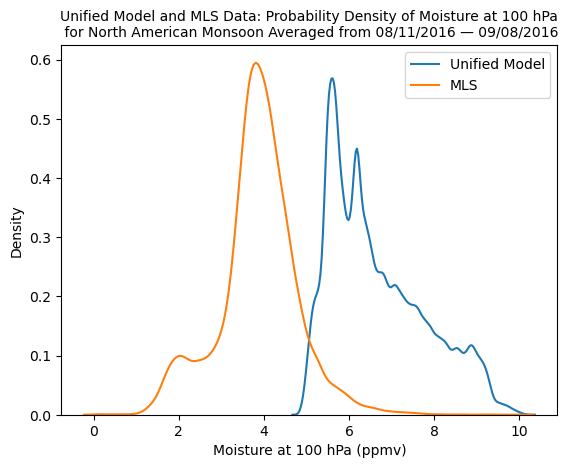

In [469]:
CreatePDF(UM_hus100_NAM_flat, MLS_NAM_arr, "North American Monsoon", source2="MLS")

Task 5: UM, GPM_MERGIR brightness temperature PDF (hourly data)

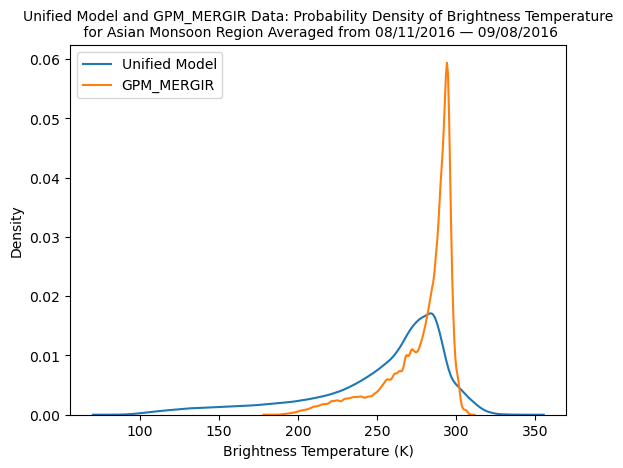

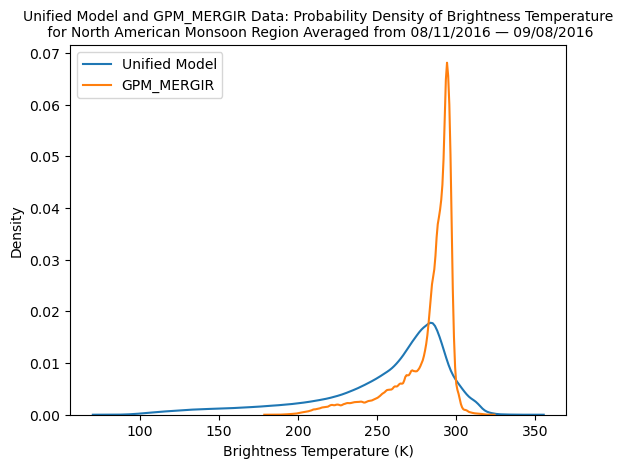

In [26]:
CreatePDF(UM_OLR_AM, GPM_OLR_AM, geographic_region="Asian Monsoon Region", data_label="Brightness Temperature")
CreatePDF(UM_OLR_NAM, GPM_OLR_NAM, geographic_region="North American Monsoon Region", data_label="Brightness Temperature")

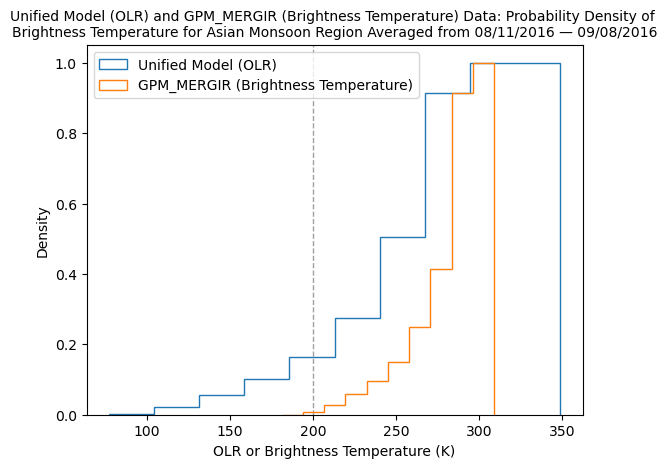

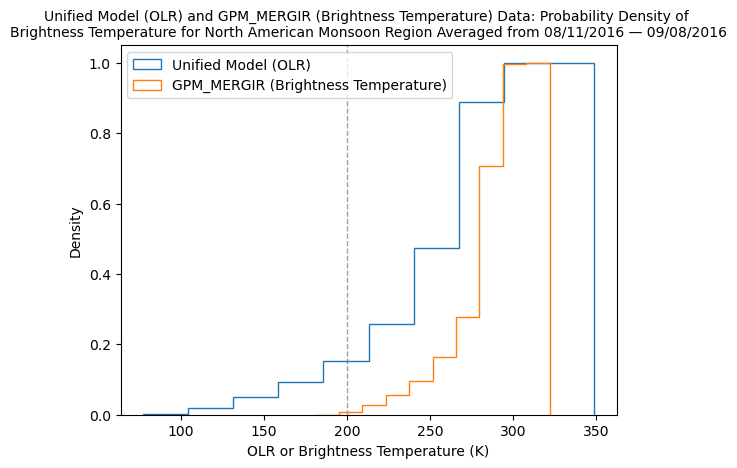

In [466]:
CreateCDF(UM_OLR_AM, GPM_OLR_AM, geographic_region="Asian Monsoon Region", data_label="Brightness Temperature")
CreateCDF(UM_OLR_NAM, GPM_OLR_NAM, geographic_region="North American Monsoon Region", data_label="Brightness Temperature")